# Brain MRI Stroke Classification 
## Transfer Learning Residual Network (ResNet) 18 layers model (Non-normalised images) 

## Set up

### Modules

#### Published modules

In [1]:
# Data Manipulation
import numpy as np

# Machine Learning
## Training, validation and test sets
from sklearn.model_selection import train_test_split

# PyTorch
## Data loading
from torch.utils.data.dataloader import DataLoader
## Pre-processing
from torchvision import transforms
## Neural Network Architecture
import torch
import torch.nn as nn
## Transfer learning
from torchvision import models
from torchvision.models import ResNet18_Weights # Pre-trained weights
## Optimisiation
from torch.optim import Adam
## Misc
from torchsummary import summary
from torch_snippets import show, inspect

# Utilities
## os
import os
import sys
## Paths
from pyhere import here
from glob import glob
## Garbage colector
import gc

#### Project specific modules

In [2]:
path_to_project_modules = os.path.join(here('Src','Modules'))
sys.path.insert(0, path_to_project_modules)

from Project.datautils import StrokeImageData # Class inheriting from torch.utils.data.dataset.Dataset to load images
from Project.visualisation import display_image_samples
from Project.architecture import convolution_layer # A set of layers comprised of Conv2d, RelU activation, Batch Normalisation and Maxpool
from Project.modeltraining import train_model, evaluate_model

### File paths

In [3]:
raw_data = os.path.join(here('Data', 'Raw')) #os.path.join transforms the output of pyhere.here from PosixPath to a text string
file_paths = glob(raw_data + '/*/*')

#### Random state

In [4]:
rand_state = 13 # For replication purposes
torch.manual_seed(rand_state)

#### PyTorch Backend

In [5]:
# Ensure the workflow is device agnostic 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} as Hardware Accelerator')

Using cuda as Hardware Accelerator


## Analysis

### Data loading and preparation

#### Data pre-processing

In [6]:
preproc_recipe = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisation degrades too much black and white images, so a model without normalisation was trained
])

#### Train, validation and test sets

In [7]:
# Store classes in a list (for stratification)
y = [_file_path.split('/')[-2] for _file_path in file_paths]

# Generate Training and test sets
X_trainval, x_test, y_trainval, _ = train_test_split(file_paths, y, test_size=0.2, shuffle=True, stratify=y, random_state=rand_state)

# Further split training set into training and validation sets
X_train, X_val = train_test_split(X_trainval, test_size = 0.2, shuffle=True, stratify=y_trainval, random_state=rand_state)

#### Data loading

In [8]:
strk_train = StrokeImageData(X_train, device = device, recipe = preproc_recipe)
strk_val = StrokeImageData(X_val, device = device, recipe = preproc_recipe)
strk_test = StrokeImageData(x_test, device = device, recipe = preproc_recipe)

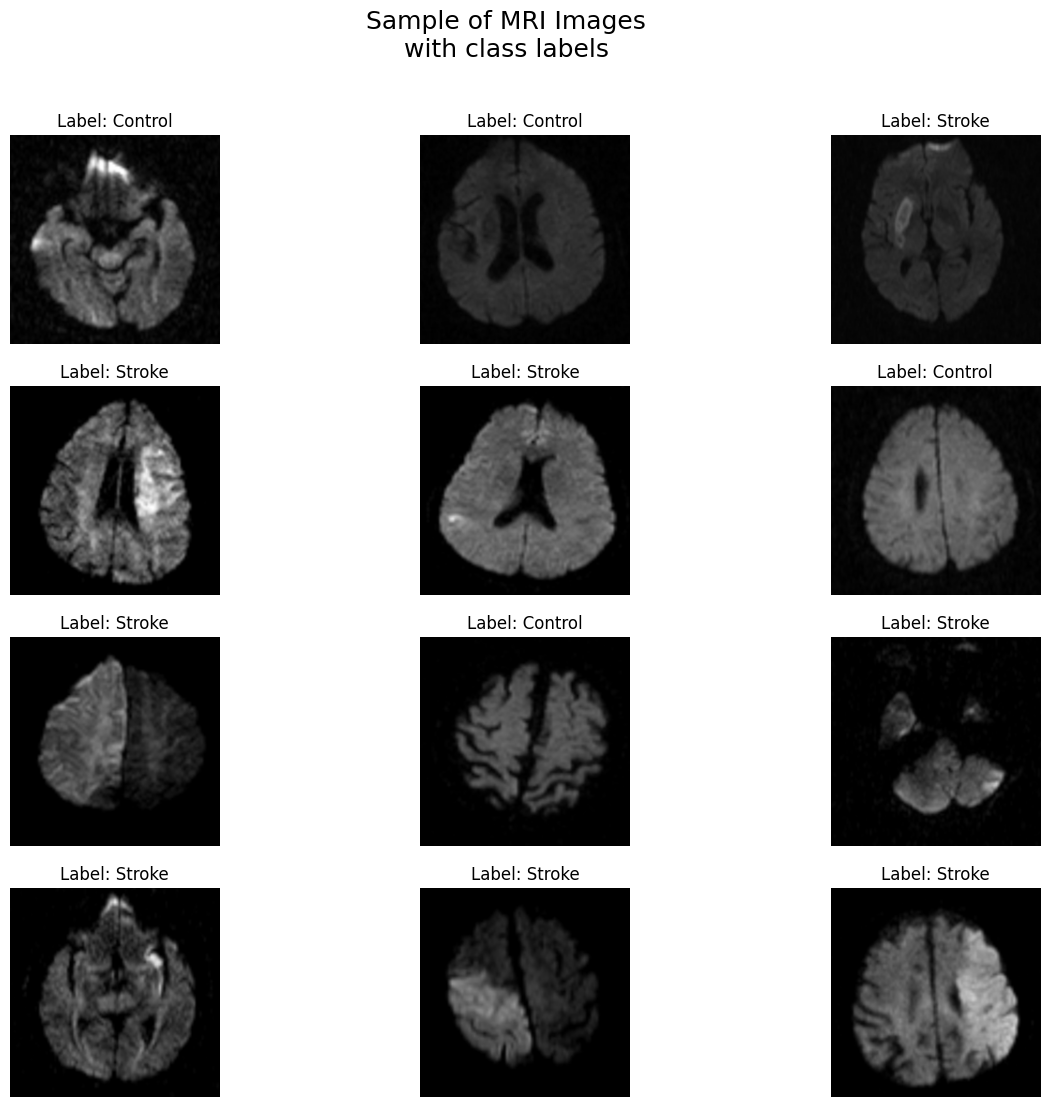

In [9]:
# Check Images are loaded correctly
display_image_samples(strk_train)

#### Data loaders

In [10]:
batch_size = 32

train_dl = DataLoader(strk_train, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 6 images

val_dl = DataLoader(strk_val, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 2 images

test_dl = DataLoader(strk_test, batch_size = batch_size, shuffle = True, drop_last = False)

### Model specification

#### Network Architecture

In [11]:
m_resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
for param in m_resnet18.parameters():
    param.requires_grad = False

m_resnet18.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

m_resnet18.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512,128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [12]:
summary(m_resnet18, input_size=(3,224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Hyperparameters

#### Epochs

In [13]:
n_epochs = 500

#### Optimiser

In [14]:
optim = Adam
lr = 1e-3

# learning rate annealing
scheduler_kws = {
    'factor':0.5, 
    'patience':0, 
    'threshold':1e-3, 
    'verbose':True, 
    'min_lr':1e-6, 
    'threshold_mode':'abs'}

# Early stop
earlystop_kws = {
    'patience': 5,
    'min_delta': 1e-3
}

#### Loss Function

In [15]:
loss_fn = nn.BCELoss() # Binary Cross Entropy

#### Model training

Learning rate annealing enabled...
Early stop enabled...
Epoch: 1;
Training accuracy: 64.06%, Training loss: 0.62845 ---------- Validation accuracy: 70.62%, Validation loss: 0.58542
Epoch: 2;
Training accuracy: 74.06%, Training loss: 0.52940 ---------- Validation accuracy: 74.06%, Validation loss: 0.51442
Epoch: 3;
Training accuracy: 76.95%, Training loss: 0.47339 ---------- Validation accuracy: 78.75%, Validation loss: 0.47737
Epoch: 4;
Training accuracy: 77.19%, Training loss: 0.46807 ---------- Validation accuracy: 80.00%, Validation loss: 0.45455
Epoch: 5;
Training accuracy: 78.91%, Training loss: 0.43458 ---------- Validation accuracy: 73.44%, Validation loss: 0.47850
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 6;
Training accuracy: 79.30%, Training loss: 0.42339 ---------- Validation accuracy: 80.00%, Validation loss: 0.43588
Epoch: 7;
Training accuracy: 81.80%, Training loss: 0.41208 ---------- Validation accuracy: 76.88%, Validation loss: 0.43599
Epoch 

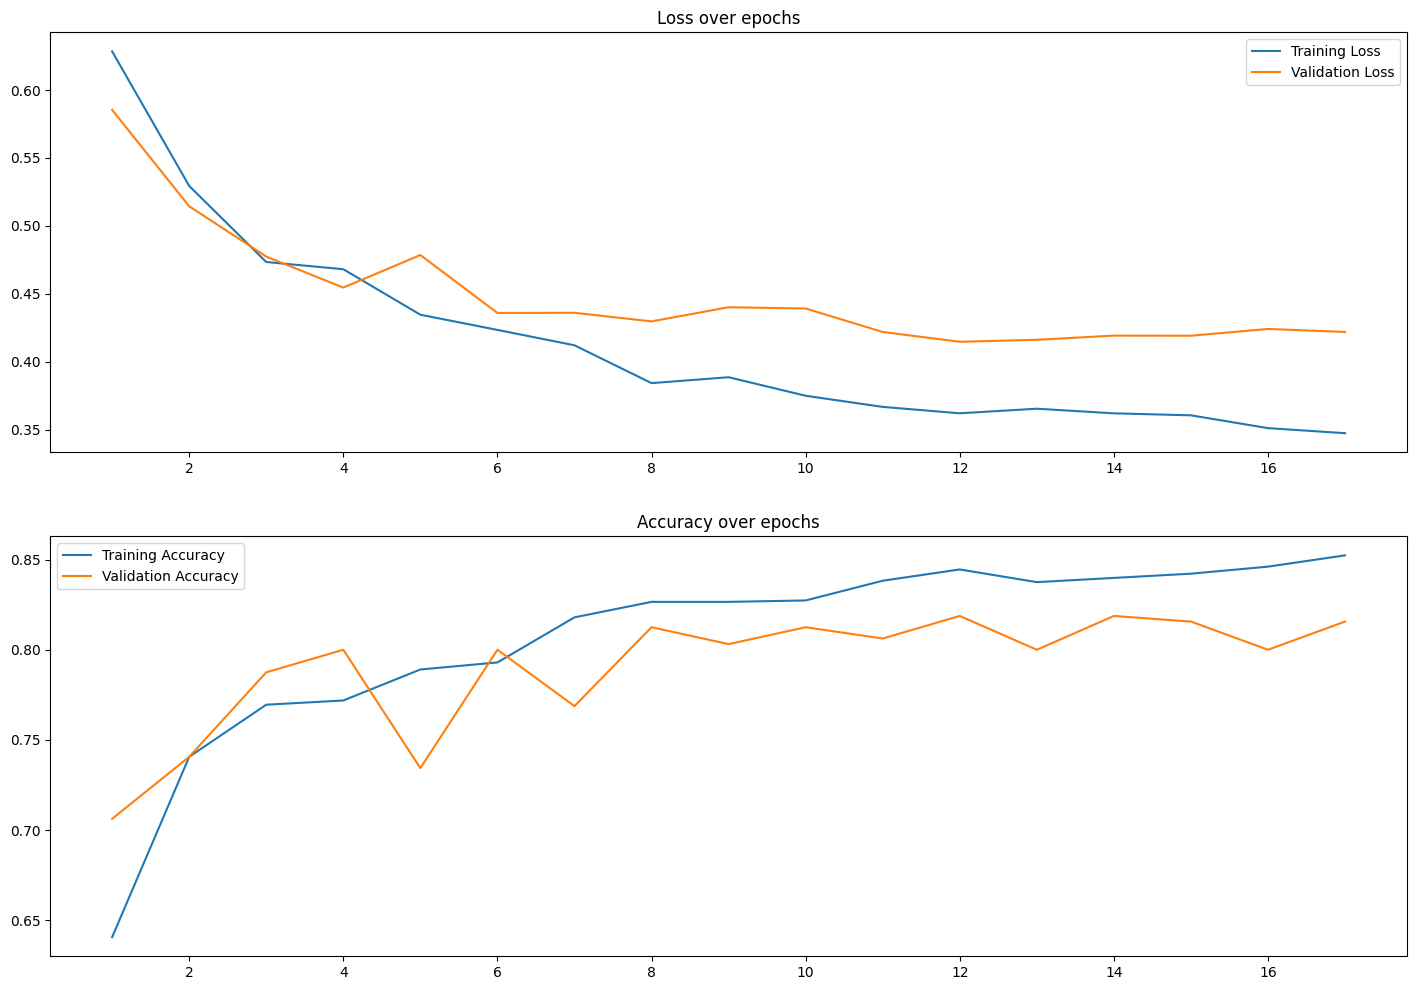

In [16]:
train_model(train_dl, val_dl, m_resnet18, loss_fn, optim, lr, n_epochs, kws_lr_scheduler = scheduler_kws, kws_early_stop = earlystop_kws)

## Performance in the Test set

In [17]:
test_acc, test_loss = evaluate_model(test_dl, m_resnet18, loss_fn, 0.5)
print(f"Test data:\n  Accuracy: {test_acc*100:.2f}%\n  Loss:    {test_loss:.5f}")

Test data:
  Accuracy: 82.09%
  Loss:    0.38183
